2024-06-05 19:07:56,550 - INFO - {"message": "Waiting for suitable server to become available", "selector": "<function writable_server_selector at 0x119dee340>", "operation": "createIndexes", "topologyDescription": "<TopologyDescription id: 666038fc57307630069e60b3, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27018) server_type: Unknown, rtt: None>]>", "clientId": {"$oid": "666038fc57307630069e60b3"}, "remainingTimeMS": 4}


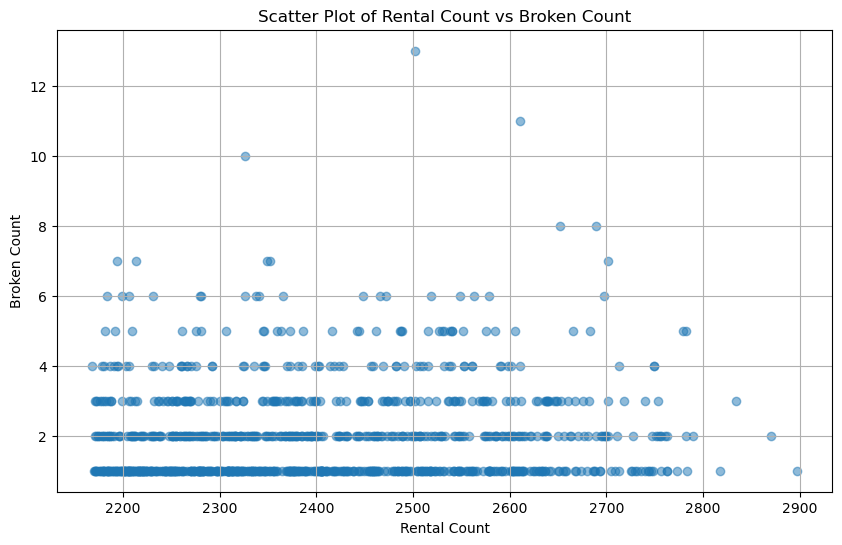

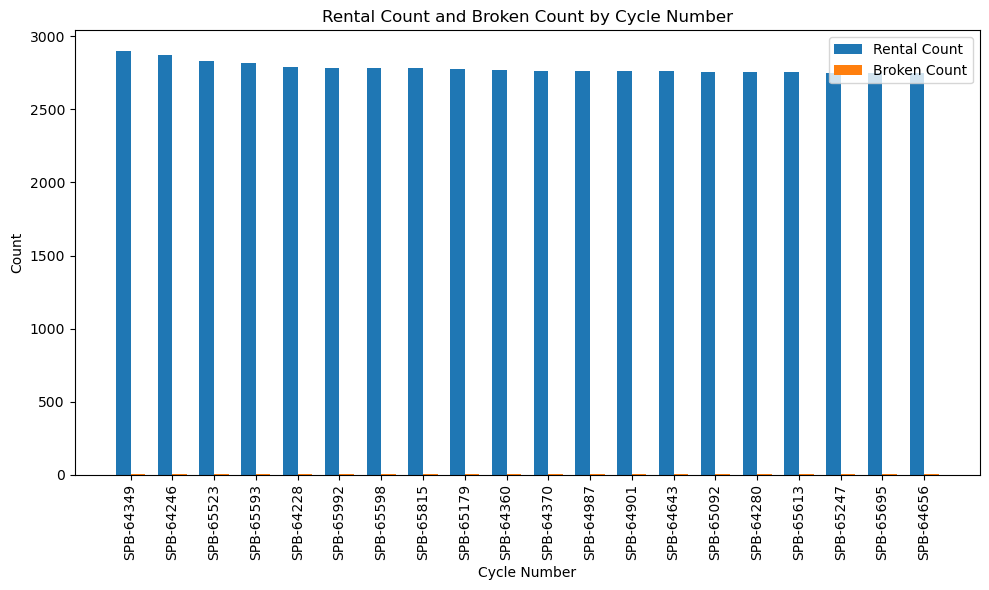

In [13]:
from pymongo import MongoClient, ASCENDING, DESCENDING
from pymongo.errors import ExecutionTimeout
import matplotlib.pyplot as plt
import pandas as pd

# MongoDB 클라이언트 설정 (적절히 수정)
client = MongoClient('mongodb://localhost:27018/', serverSelectionTimeoutMS=5000)
db = client['cycle']

# 필요한 필드에 인덱스 추가
db.broken_history.create_index([('cycle_num', ASCENDING)])
db.rental_info.create_index([('cycle_num', ASCENDING)])

# Aggregation 파이프라인
pipeline = [
    {
        "$group": {
            "_id": "$cycle_num",
            "broken_count": { "$sum": 1 }
        }
    },
    {
        "$lookup": {
            "from": "rental_info",
            "localField": "_id",
            "foreignField": "cycle_num",
            "as": "rental_data"
        }
    },
    {
        "$unwind": "$rental_data"
    },
    {
        "$group": {
            "_id": "$_id",
            "broken_count": { "$first": "$broken_count" },
            "rental_count": { "$sum": 1 }
        }
    },
    {
        "$project": {
            "cycle_num": "$_id",
            "broken_count": 1,
            "rental_count": 1,
            "correlation": { "$divide": ["$broken_count", "$rental_count"] }
        }
    },
    {
        "$sort": { "rental_count": -1 }
    },
    {
        "$limit": 1000
    }
]

# Aggregation 실행
try:
    result = list(db.broken_history.aggregate(pipeline, allowDiskUse=True, maxTimeMS=30000000))  # 타임아웃 시간을 5분으로 연장
    # 결과를 DataFrame으로 변환
    df = pd.DataFrame(result)
    
    # 산점도 시각화
    plt.figure(figsize=(10, 6))
    plt.scatter(df['rental_count'], df['broken_count'], alpha=0.5)
    plt.title('Scatter Plot of Rental Count vs Broken Count')
    plt.xlabel('Rental Count')
    plt.ylabel('Broken Count')
    plt.grid(True)
    plt.show()

    # 막대 그래프 시각화
    df_sorted = df.sort_values(by='rental_count', ascending=False).head(20)  # 상위 20개의 자전거만 표시
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(df_sorted))

    bar1 = plt.bar(index, df_sorted['rental_count'], bar_width, label='Rental Count')
    bar2 = plt.bar([i + bar_width for i in index], df_sorted['broken_count'], bar_width, label='Broken Count')

    plt.xlabel('Cycle Number')
    plt.ylabel('Count')
    plt.title('Rental Count and Broken Count by Cycle Number')
    plt.xticks([i + bar_width / 2 for i in index], df_sorted['cycle_num'], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

except ExecutionTimeout:
    print("Aggregation query exceeded time limit")